# Data Analysis 3 - First Home Assignment
## Author: Márton Nagy

## Part 1: Modelling
### 1.1. - Data wrangling

In [101]:
import pandas as pd
import numpy as np
import math
import ast
from datetime import datetime
from time import time
from plotnine import *
import seaborn as sns
import patchworklib as pw
from IPython.display import display
from mizani.formatters import percent_format
from pathlib import Path
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.compose import ColumnTransformer
from sklearn.inspection import (
    partial_dependence,
    permutation_importance,
    PartialDependenceDisplay,
)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

from utils.py_helper_functions import *

import dill
import json
import shap

My chosen AirBnB dataset is: Milan (2024Q2). I will check the validity of my models on data from Milan (2024Q3) and Florence (2024Q2).

First, I read the raw CSV files (as they have been downloaded from the InsideAirBnB website).

In [56]:
# read raw data files
data_dir = 'raw_data'
milanQ2 = pd.read_csv(Path(data_dir, 'Milan2024Q2.csv'), index_col = 0)
milanQ3 = pd.read_csv(Path(data_dir, 'Milan2024Q3.csv'), index_col = 0)
florenceQ2 = pd.read_csv(Path(data_dir, 'Florence2024Q2.csv'), index_col = 0)

Sometimes when I worked with InsideAirBnB data, I noticed that different cities or timeframes may have different variables available. This may pose a problem in the sense, that if I build a model on Milan Q2 using some variables that are not available in the 'live' data, than my models would be practically useless.

Note that in this case, this is actually not a problem - but better to be safe than sorry.

In [57]:
# keep only such columns that are present in all dataframes
# for these dataframes, this actually does not drop anything
# but this may not be the case for other data
milanQ2.drop([col for col in milanQ2 if col not in set(milanQ2.columns).intersection(set(milanQ3.columns)).intersection(set(florenceQ2))], inplace = True, axis = 1)
milanQ3.drop([col for col in milanQ3 if col not in set(milanQ2.columns).intersection(set(milanQ3.columns)).intersection(set(florenceQ2))], inplace = True, axis = 1)
florenceQ2.drop([col for col in florenceQ2 if col not in set(milanQ2.columns).intersection(set(milanQ3.columns)).intersection(set(florenceQ2))], inplace = True, axis = 1)

As I figured that I cannot use the neighbourhood variables for my models (as they would be completely different for Florence), I instead will calculate the distance to the city center (using the haversine formula) and use this instead.

In [58]:
def distance_to_center(lat, lon, center_lat, center_lon):
    # radius of Earth in kilometers
    R = 6371.0
    
    # convert degrees to radians
    lat1, lon1 = math.radians(center_lat), math.radians(center_lon)
    lat2, lon2 = math.radians(lat), math.radians(lon)
    
    # differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    # distance in kilometers
    distance = R * c
    
    return distance

During development, I first cleaned the MilanQ2 table step-by-step, making a concious decision at every step. However, as I also have to clean two other datasets the same way, I decided to wrap the whole cleaning process inside a function.

The key steps of the cleaning process were:

- type conversions (and possibly cleaning values for that from unnecessary characters);
- imputing missing values - for categorical columns, I did this by adding a new 'Missing' category; for numerical columns I usually imputed with the median value (except for host response rate and host acceptance rate, where I imputed with zeros);
- deciding on the measurement scale for certain quantitative variables (categorical or numerical);
- creating flags for missing values for variables where a substantial amount was missing;
- filtering to a sensible subset by property type, number of people accomodated and minimum nights, and also filtering out observations with no target variable;
- making some new variables (days since host, days since first review, distance to center;
- creating dummies from the amenities and the host verification types.
    

In [62]:
def clean_df(df, center_lat, center_lon):
    df = df.copy() #not inplace

    # number of days the host is registered (no missing)
    df['n_host_since'] = (pd.to_datetime(df['last_scraped'], format = '%Y-%m-%d') - pd.to_datetime(df['host_since'], format = '%Y-%m-%d')).dt.days

    # host location Italy or Other, NAs imputed with missing category
    df['f_host_location'] = df['host_location'].apply(
        lambda x: 'Italy' if isinstance(x, str) and 'italy' in x.lower() else ('Missing' if pd.isna(x) else 'Other')).astype('category')

    # simple categorical, added Missing category for NAs
    df['f_host_response_time'] = df['host_response_time'].fillna('Missing').astype('category')

    # converted to numeric scale, imputed 0s for missing values (based on Ch16 case study code)
    df['p_host_response_rate'] = df.host_response_rate.fillna('0%').apply(lambda x: int(x.strip('%')))

    # converted to numeric scale, imputed 0s for missing values (based on Ch16 case study code)
    df['p_host_acceptance_rate'] = df.host_acceptance_rate.fillna('0%').apply(lambda x: int(x.strip('%')))

    # converted to binary, no missing
    df['d_host_is_superhost'] = df.host_is_superhost.apply(lambda x: 1 if x == 't' else 0)

    # added dummies for every possible host verification type (only three in practice)
    df = df.join(df['host_verifications'].apply(ast.literal_eval).apply(lambda x: pd.Series(1, index=x)).fillna(0).astype(int).add_prefix('d_hostverif_'))

    # converted to binary, no missing
    df['d_host_has_profile_pic'] = df.host_has_profile_pic.apply(lambda x: 1 if x == 't' else 0)

    # converted to binary, no missing
    df['d_host_identity_verified'] = df.host_identity_verified.apply(lambda x: 1 if x == 't' else 0)

    # I figured that I should not use neighbourhood data in my models, as in the case of Florence live data, I will have completely different values
    # So instead, I will use distance to center (calculated by me).
    #df['f_neighbourhood'] = df.neighbourhood_cleansed.astype('category')

    # Filtering to a sensible set of property types
    df = df.loc[lambda x: x['property_type'].isin(['Entire rental unit', 'Entire condo', 'Private room in rental unit', 'Private room in condo',
                                          'Entire loft', 'Entire home', 'Private room in loft', 'Private room in home'])]

    # Setting values to categories, no missing
    df['f_property_type'] = df.property_type.astype('category')

    # Setting values to categories, no missing
    df['f_room_type'] = df.room_type.astype('category')

    # Not interested in extremely big listings, filtering to max. 8 guests
    df = df[df['accommodates'] <= 8]
    df['n_accomodates'] = df.accommodates

    # Creating bathroom categories (1, 2 and 2+)
    df['f_bathrooms'] = df.bathrooms.fillna(1).apply(lambda x: '0' if x < 1 else ('1' if (x >= 1 and x < 2) else ('2' if (x >= 2 and x < 3) else '2+'))).astype('category')

    # Imputing the number of bedrooms with the median
    df['n_bedrooms'] = df.bedrooms.fillna(np.median(df['bedrooms'].dropna()))

    # Imputing the number of beds with the number of possible guests
    df['n_beds'] = df.beds.fillna(df['accommodates'])

    # Adding a dummy for all possible amenities (will remove many later)
    df = df.join(df['amenities'].apply(lambda x: pd.Series(1, index=[amen.replace(' ', '_').replace('-', '_').lower() for amen in ast.literal_eval(x)])).add_prefix('d_amenities_').fillna(0).astype(int))

    # Dropping observations where no price (target), converting it to float
    df = df[df['price'].notna()]
    df['eur_price'] = df.price.apply(lambda x: x.replace('$', '').replace(',', '')).astype(float)

    # Interested in AirBnBs for short-term tourism: minimum nights should not be more than a week
    df = df[df['minimum_nights'] <= 7]

    # Categorizing the number of reviews: 0, 1-10, 11-30, 30+
    fnor = pd.cut(df['number_of_reviews'].to_list(),
       pd.IntervalIndex.from_tuples([(0, 1), (1, 11), (11, 31), (31, max(df.number_of_reviews)+1)], closed="left"),
       labels=['0', '1-10', '11-30', '30+'])
    fnor = fnor.rename_categories([0, 1, 2, 3])
    df['f_number_of_reviews'] = fnor

    # Calculating number of days since the first review
    df["n_days_since_first_rev"] = (
    df.last_scraped.apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
        - df.first_review.fillna("1950-01-01").apply(
            lambda x: datetime.strptime(x, "%Y-%m-%d")
        )).dt.days
    df["n_days_since_first_rev"] = np.where(df.first_review.isnull(), np.nan, df.n_days_since_first_rev)

    # adding prefix, will deal with missing later
    df['n_review_scores_rating'] = df.review_scores_rating

    # converting to binary, no missing
    df['d_instant_bookable'] = df.instant_bookable.apply(lambda x: 1 if x == 't' else 0)

    # Categorizing host listings count: 1, 2-10, 10+
    hlc = pd.cut(df['calculated_host_listings_count'].to_list(),
       pd.IntervalIndex.from_tuples([(0, 2), (2, 11), (11, max(df.calculated_host_listings_count)+1)], closed="left"),
       labels=['1', '2-10', '10+'])
    hlc = hlc.rename_categories([0, 1, 2])
    df['f_host_listings_count'] = hlc

    # Adding prefix, will deal with missing later
    df['n_reviews_per_month'] = df.reviews_per_month

    # calculating distance to city center
    df['n_distance_to_center'] = df.apply(lambda row: distance_to_center(row['latitude'], row['longitude'], center_lat, center_lon), axis=1)

    # filtering to columns with prefixes
    df = df.filter(regex="^d_.*|^n_.*|^f_.*|^p_.*|^eur_.*",)

    # creating flags for variables that had many missing values, and imputing with median
    df = df.assign(
        flag_n_days_since_first_rev = np.multiply(df.n_days_since_first_rev.isna(), 1),
        n_days_since_first_rev = df.n_days_since_first_rev.fillna(np.median(df.n_days_since_first_rev.dropna())),
        flag_n_review_scores_rating = np.multiply(df.n_review_scores_rating.isna(), 1),
        n_review_scores_rating = df.n_review_scores_rating.fillna(
            np.median(df.n_review_scores_rating.dropna())
        ),
        flag_n_reviews_per_month = np.multiply(df.n_reviews_per_month.isna(), 1),
        n_reviews_per_month = df.n_reviews_per_month.fillna(
            np.median(df.n_reviews_per_month.dropna())
        )
    )

    return df

For calculating the distance to center, I manually looked up the city center coordinates for both cities.

In [64]:
milan_lat = 45.464664
milan_lon = 9.188540
florence_lat = 43.769562
florence_lon  = 11.255814

Applying the cleaning function to MilanQ2.

In [66]:
milanQ2 = clean_df(milanQ2, milan_lat, milan_lon)

As there were a couple thousand different amenities in the dataset, I decided to only keep those, that were present at at least a quarter of the observations.

In [67]:
# keep only such amenities in our source data that are present at at least 25% of the listings
milanQ2.drop([col for col in milanQ2.columns if ('d_amenities' in col and milanQ2[col].sum() < milanQ2.shape[0]*0.25)], inplace = True, axis = 1)

Note that I apply the cleaning function here (that is actually task 5 in the assignment description). The reason for this is that I only want to have such amenities in my training data that are also present in the 'live' data as well.

In [68]:
milanQ3 = clean_df(milanQ3, milan_lat, milan_lon)

In [69]:
florenceQ2 = clean_df(florenceQ2, florence_lat, florence_lon)

In [70]:
# filter out such host_verifs and amenities that are not present in all tables
# the other cols are common as we have created them
milanQ2.drop([col for col in milanQ2 if col not in set(milanQ2.columns).intersection(set(milanQ3.columns)).intersection(set(florenceQ2))], inplace = True, axis = 1)
milanQ3.drop([col for col in milanQ3 if col not in set(milanQ2.columns).intersection(set(milanQ3.columns)).intersection(set(florenceQ2))], inplace = True, axis = 1)
florenceQ2.drop([col for col in florenceQ2 if col not in set(milanQ2.columns).intersection(set(milanQ3.columns)).intersection(set(florenceQ2))], inplace = True, axis = 1)

I also add squared and cubed polynomials to my datasets.

In [71]:
def add_poly_vars(df):
    df = df.copy()
    numeric_cols = [col for col in df if col[0:2] == 'n_']
    for c in numeric_cols:
        df[f'sq_{c}'] = np.power(df[c], 2)
        df[f'cu_{c}'] = np.power(df[c], 3)
    return df

In [72]:
milanQ2 = add_poly_vars(milanQ2)
milanQ3 = add_poly_vars(milanQ3)
florenceQ2 = add_poly_vars(florenceQ2)

All in all, I am left with 20,730 observations in my MilanQ2 dataset.

In [73]:
milanQ2[[col for col in milanQ2 if col[0:2] == 'n_']].describe().T

,count,mean,std,min,25%,50%,75%,max
n_host_since,20730.0,2541.313362,1336.679403,3.000000,1438.000000,2930.000000,3606.000000,5576.000000
n_accomodates,20730.0,3.224940,1.367177,1.000000,2.000000,3.000000,4.000000,8.000000
n_bedrooms,20730.0,1.178244,0.580381,0.000000,1.000000,1.000000,1.000000,5.000000
n_beds,20730.0,1.603232,1.122176,0.000000,1.000000,1.000000,2.000000,17.000000
n_days_since_first_rev,20730.0,864.561119,967.593807,0.000000,251.000000,480.000000,989.000000,5178.000000
n_review_scores_rating,20730.0,4.731977,0.387399,0.000000,4.670000,4.840000,4.960000,5.000000
n_reviews_per_month,20730.0,1.690186,1.907503,0.010000,0.470000,1.010000,2.140000,27.690000
n_distance_to_center,20730.0,3.003237,1.529555,0.037974,1.885192,2.823209,3.841611,9.679887


If we look at the price distribution, we can see that there are some extremely large values. I believe these are rather errors, so I drop these observations.

In [74]:
milanQ2.eur_price.describe(percentiles=[0.01,0.05,0.25, 0.5, 0.75, 0.95, 0.99])

count    20730.000000
mean       179.544621
std        967.429763
min         12.000000
1%          42.000000
5%          56.000000
25%         83.000000
50%        110.000000
75%        163.000000
95%        394.000000
99%       1000.000000
max      90000.000000
Name: eur_price, dtype: float64

In [75]:
# prices above 1000 EUR are clearly erronous - and we should not try to predict errors
milanQ2 = milanQ2[milanQ2['eur_price'] <= 1000]

I apply a 70%-30% train vs. hold-out split. This means a 14K observation training sample.

In [76]:
data_train, data_holdout = train_test_split(milanQ2, train_size=0.7, random_state=42)

### 1.2. Building predictive models

With the clean dataset at hand, we can now begin building models. I will build five predictive models:

1. simple OLS (trying different specifications with 5-fold cross-validation);
2. LASSO (starting from the most complex OLS specification);
3. Random Forest (with moderate tuning);
4. GBM (with minimal tuning);
5. XGBoost (with moderate tuning).

Note that the level of tuning for the last three models is mainly determined by the computational limitations of my computer.

First, I group my variables into certain categories to be able to easily construct variable sets.

In [77]:
basic_vars = ('f_property_type', 'f_room_type', 'n_accomodates', 'f_bathrooms', 'n_bedrooms', 'n_beds', 'n_distance_to_center', 'd_instant_bookable')
host_vars = ('n_host_since', 'f_host_location', 'f_host_response_time', 'p_host_response_rate', 'p_host_acceptance_rate', 'd_host_is_superhost',
             'd_hostverif_email', 'd_hostverif_phone', 'd_hostverif_work_email', 'd_host_has_profile_pic', 'd_host_identity_verified',
             'f_host_listings_count')
review_vars = ('f_number_of_reviews', 'n_days_since_first_rev', 'n_review_scores_rating', 'n_reviews_per_month', 'flag_n_days_since_first_rev',
              'flag_n_review_scores_rating', 'flag_n_reviews_per_month')
amenities = tuple([col for col in data_train if 'd_amenities_' in col])
poly_vars = tuple([col for col in data_train if col[0:2] in ['sq', 'cu']])

The below variables will be used to train RF, GBM and XGBoost models (thus no polynomials or interactions are specified).

In [79]:
predictors_ml = basic_vars + host_vars + review_vars + amenities

For the OLS models, I wanted to uncover some possible interaction terms. For this, I used a graphical approach. In code comments, I indicated whether I have deemed the graphical evidence strong enough to include a certain interaction term.

Note that I have tweaked the pre-written utility function a bit so that it can also be used to visualize factor-factor interactions.

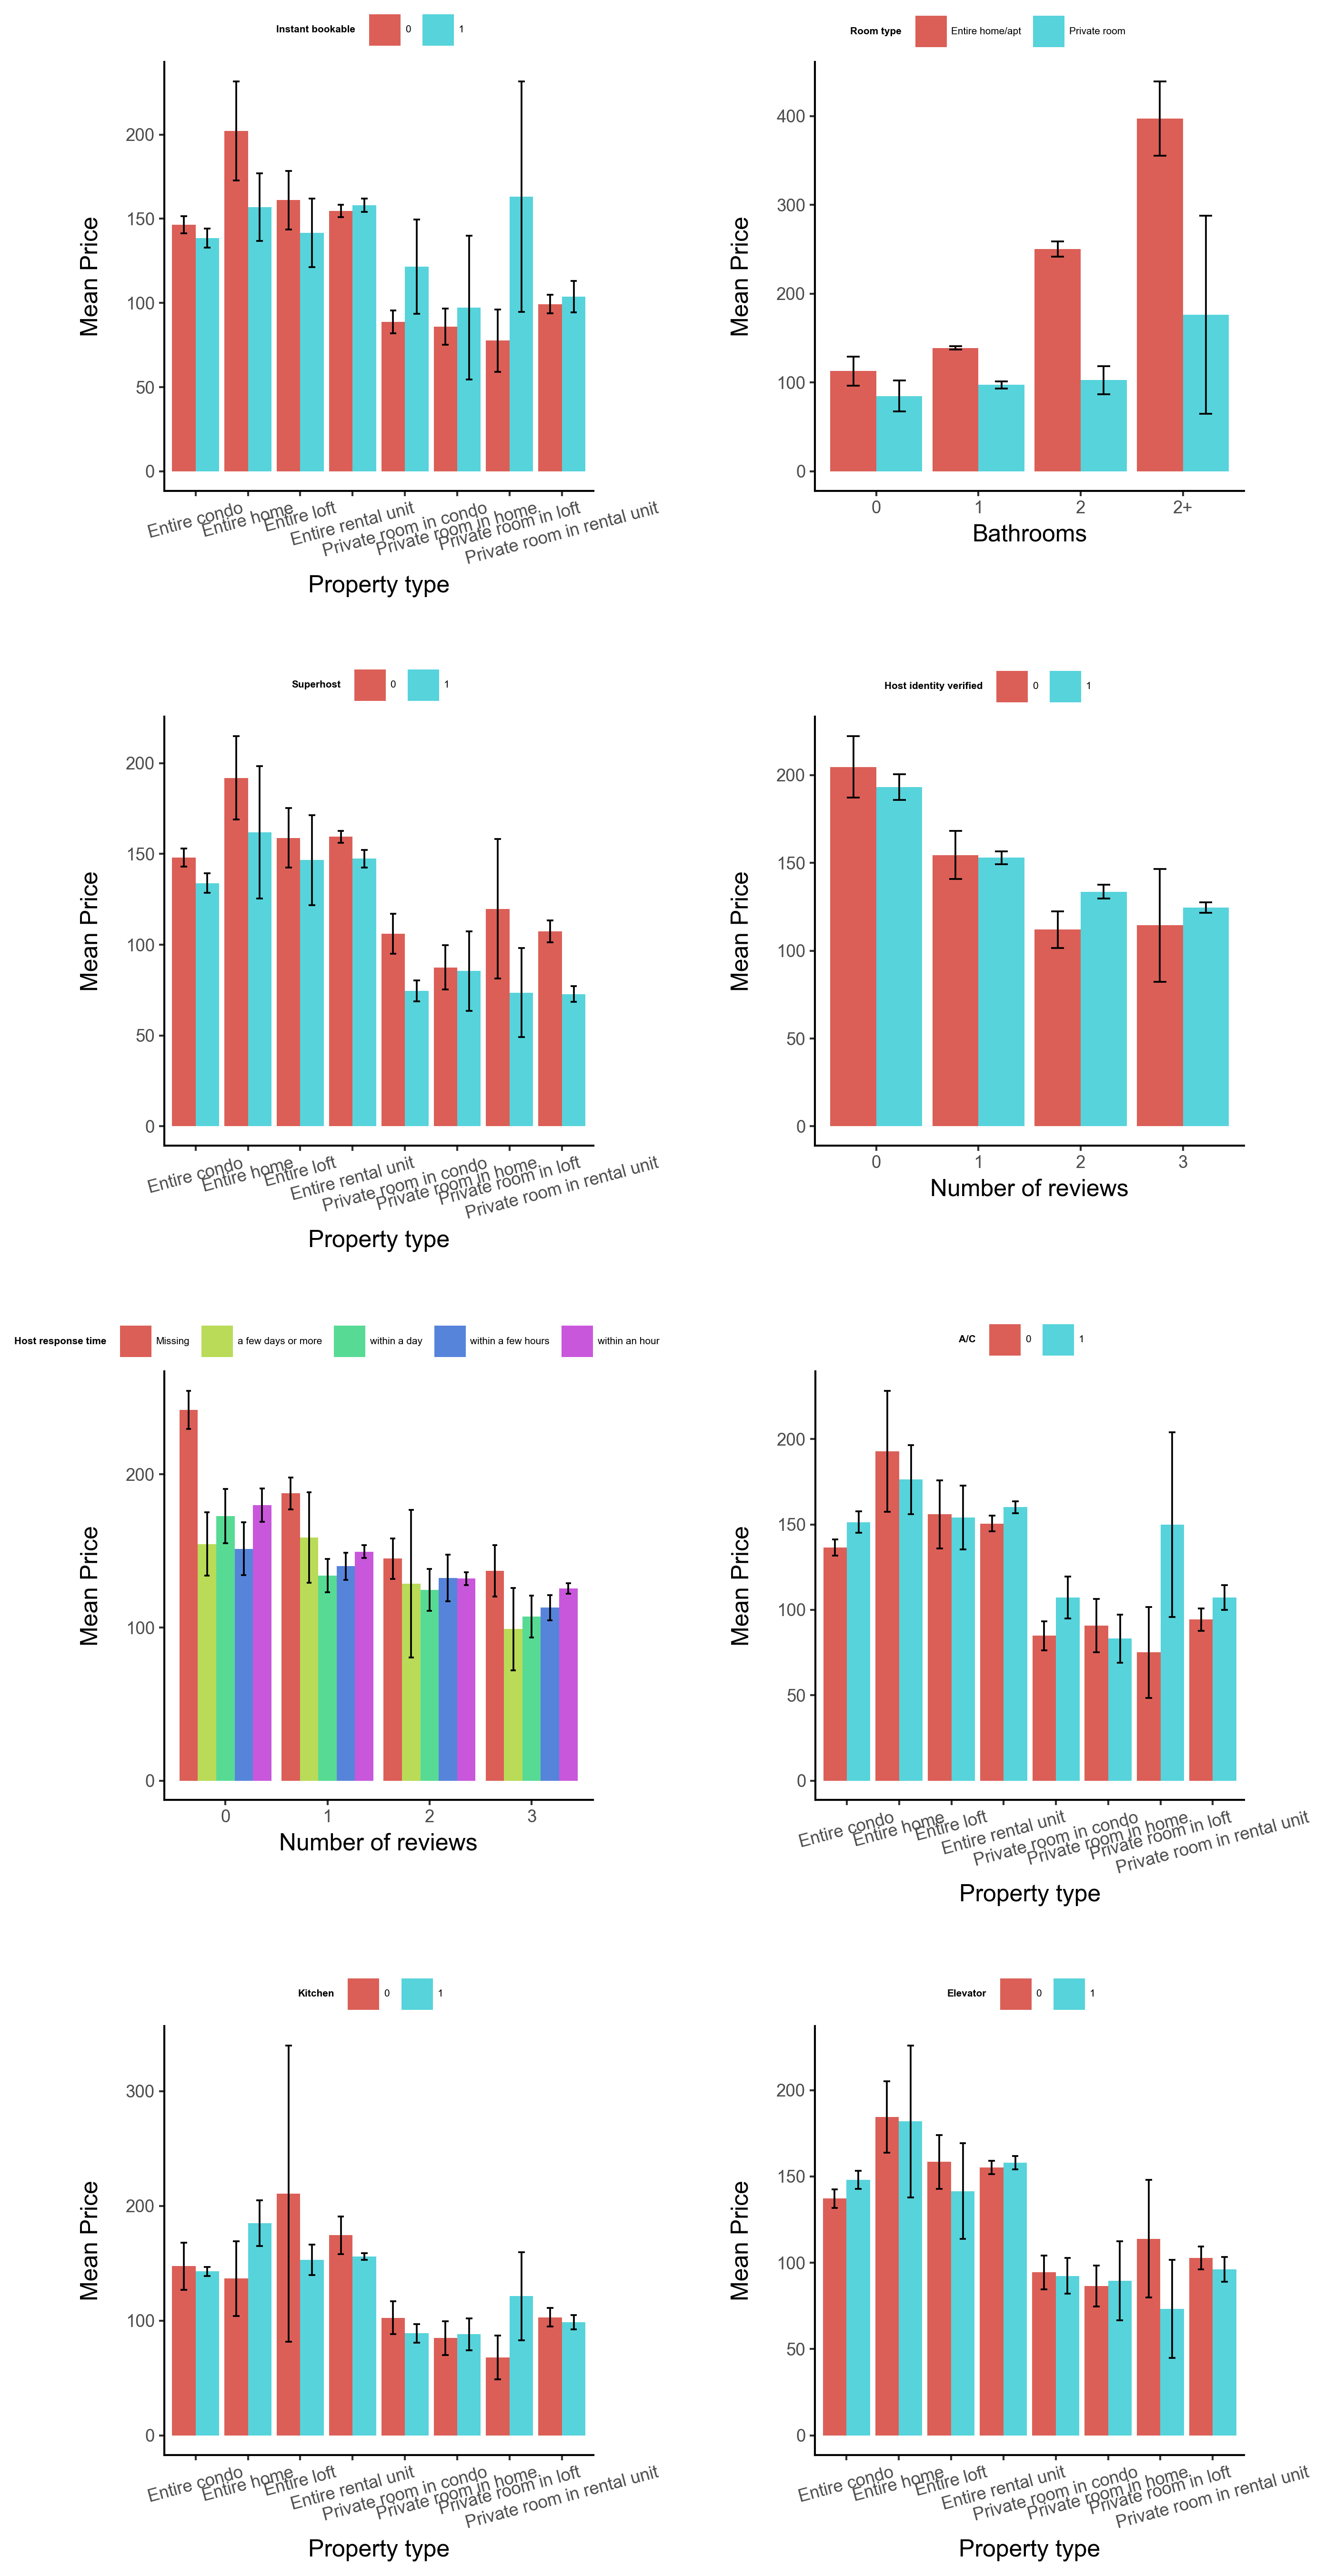

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [28]:
# interaction
p1 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_property_type', 'd_instant_bookable',
                        'Property type', 'Instant bookable') + theme(axis_text_x=element_text(angle = 15))

# no interaction
p2 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_bathrooms', 'f_room_type',
                        'Bathrooms', 'Room type')

# no interaction
p3 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_property_type', 'd_host_is_superhost',
                        'Property type', 'Superhost') + theme(axis_text_x=element_text(angle = 15))

# no interaction
p4 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_number_of_reviews', 'd_host_identity_verified',
                        'Number of reviews', 'Host identity verified')

# interaction
p5 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_number_of_reviews', 'f_host_response_time',
                        'Number of reviews', 'Host response time')

# interaction
p6 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_property_type', 'd_amenities_air_conditioning',
                        'Property type', 'A/C') + theme(axis_text_x=element_text(angle = 15))

# interaction
p7 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_property_type', 'd_amenities_kitchen',
                        'Property type', 'Kitchen') + theme(axis_text_x=element_text(angle = 15))

# no interaction
p8 = price_diff_by_variables(data_train.rename(columns={'eur_price': 'price'}), 'f_property_type', 'd_amenities_elevator',
                        'Property type', 'Elevator') + theme(axis_text_x=element_text(angle = 15))

g1 = pw.load_ggplot(p1, figsize=(3, 3))
g2 = pw.load_ggplot(p2, figsize=(3, 3))
g3 = pw.load_ggplot(p3, figsize=(3, 3))
g4 = pw.load_ggplot(p4, figsize=(3, 3))
g5 = pw.load_ggplot(p5, figsize=(3, 3))
g6 = pw.load_ggplot(p6, figsize=(3, 3))
g7 = pw.load_ggplot(p7, figsize=(3, 3))
g8 = pw.load_ggplot(p8, figsize=(3, 3))

interactions = (g1 | g2) / (g3 | g4 ) / (g5 | g6) / (g7 | g8)

display(interactions)

Having some interaction terms, we can now construct some OLS model equations in increasing complexity.

In [80]:
interaction_vars = ('f_property_type*d_instant_bookable', 'f_number_of_reviews*f_host_response_time',
                   'f_property_type*d_amenities_air_conditioning', 'f_property_type*d_amenities_kitchen')

In [81]:
ols_equations = [
    "~" + " + ".join(basic_vars),
    "~" + " + ".join(basic_vars + host_vars + review_vars),
    "~" + " + ".join(basic_vars + host_vars + review_vars + poly_vars),
    "~" + " + ".join(basic_vars + host_vars + review_vars + poly_vars + amenities),
    "~" + " + ".join(basic_vars + host_vars + review_vars + poly_vars + amenities + interaction_vars),
    ("~" + " + ".join(basic_vars + host_vars + review_vars + poly_vars + amenities + interaction_vars) 
     + " + " + "(f_property_type + f_room_type + f_number_of_reviews) * (" + "+".join(amenities) + ")")
]

# DO NOT RUN CODE FROM HERE

The best OLS model is found through 5-fold cross-validation.

In [31]:
start_time = time()
cv_list = []
for model in ols_equations:
    cv_list += [ols_crossvalidator("eur_price" + model, data_train, 5, rstate = 1234)]
model_times = {
    'ols' : time() - start_time
}

Technically, the best model (by test RMSE) would be M5 - but instead, I have decided to work further with M4 instead, as its test RMSE is practically the same, but it is less complex.

In [51]:
compare_model_fits = (
    pd.DataFrame(cv_list)
    .round(2)
    .assign(
        Model=["M" + str(i + 1) for i in range(len(cv_list))],
        BIC=lambda x: x["BIC"].astype(int),
        Coefficients=lambda x: x["Coefficients"].astype(int),
    )
    .filter(["Model", "Coefficients", "R-squared", "BIC", "Training RMSE", "Test RMSE"])
)
compare_model_fits

,Model,Coefficients,R-squared,BIC,Training RMSE,Test RMSE
0,M1,16,0.17,177410,113.70,113.80
1,M2,39,0.24,176451,109.12,109.45
2,M3,55,0.26,176116,107.26,107.95
3,M4,98,0.27,176337,106.52,107.54
4,M5,131,0.28,176547,106.09,107.48
5,M6,532,0.30,179871,103.89,108.85


Finally, I re-fitted the best model on the whole train sample.

In [52]:
y, X = dmatrices("eur_price" + ols_equations[3], data_train)
ols_model = LinearRegression().fit(X, y)

I also save into dill files my models, and the timing estimate to a JSON.

In [55]:
with open("model_times.json", "w") as f:
    json.dump(model_times, f)
with open(Path("model_dills", "ols_model_cv.dill"), "wb") as f:
    dill.dump(cv_list, f)
with open(Path("model_dills", "ols_model.dill"), "wb") as f:
    dill.dump(ols_model, f)

Next, I fit a LASSO model, starting from the most complex equation (M6). I find the tuning parameter through cross-validation. Note, however, that the tuning range was iteratively found using the plot presented later. Note that for proper results, I have to standardize my predictors. I will use the same scaler to standardize the hold-out and the live-data as well.

In [217]:
lasso_model = ElasticNet(l1_ratio=1, fit_intercept=True, random_state= 9876)
lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha": [i / 100 for i in range(20, 55, 2)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=0,
)
y, X = dmatrices("eur_price" + ols_equations[5], data_train)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
start_time = time()
lasso_model_cv.fit(X_scaled, y.ravel())
model_times['lasso'] = time() - start_time

I then save my results.

In [221]:
with open("model_times.json", "w") as f:
    json.dump(model_times, f)
with open(Path("model_dills", "lasso_model.dill"), "wb") as f:
    dill.dump(lasso_model_cv.best_estimator_, f)
with open(Path("model_dills", "lasso_model_cv.dill"), "wb") as f:
    dill.dump(lasso_model_cv, f)

The next model is a Random Forest. I set n-estimators to 250, and include moderate tuning.

In [243]:
rfr = RandomForestRegressor(
    random_state=485,
    criterion="squared_error",
    n_estimators=250,
    oob_score=True,
    n_jobs=7,
)

tune_grid = {"max_features": [8, 10, 12, 14, 16], "min_samples_split": [3, 5, 10, 15]}

rf_random = GridSearchCV(
    rfr, tune_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=0
)

y, X = dmatrices("eur_price ~ " + " + ".join(predictors_ml), data_train)

start_time = time()
rf_model_cv = rf_random.fit(X, y.ravel())
model_times['rf'] = time() - start_time

The results are then saved.

In [244]:
with open("model_times.json", "w") as f:
    json.dump(model_times, f)
with open(Path("model_dills", "rf_model.dill"), "wb") as f:
    dill.dump(rf_model_cv.best_estimator_, f)
with open(Path("model_dills", "rf_model_cv.dill"), "wb") as f:
    dill.dump(rf_model_cv, f)

The first boosting model is a GBM one. I could only provide very simple tuning to avoid computational issues.

In [53]:
gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20, random_state = 31)

tune_grid = {"n_estimators": [i for i in range(200, 500, 50)], "max_depth": [1, 5, 10]}

gbm_model_cv = GridSearchCV(
    gbm, tune_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=0, n_jobs=-1
)

categorical_columns = [col for col in predictors_ml if col.startswith("f_")]
numerical_columns = [col for col in predictors_ml if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose = False
)

start_time = time()
gbm_pipe.fit(data_train[list(predictors_ml)], data_train.eur_price)
timespan = time() - start_time
model_times['gbm'] = timespan

I again save the results.

In [56]:
with open("model_times.json", "w") as f:
    json.dump(model_times, f)
with open(Path("model_dills", "gbm_model.dill"), "wb") as f:
    dill.dump(gbm_model_cv.best_estimator_, f)
with open(Path("model_dills", "gbm_model_cv.dill"), "wb") as f:
    dill.dump(gbm_model_cv, f)

The final model is an XGBoost regression with moderate tuning.

In [60]:
xgb = XGBRegressor(
    tree_method="hist", 
    objective="reg:squarederror",
    random_state = 56
)

tune_grid = {
    "n_estimators": [250, 350, 450],  
    "max_depth": [3, 6, 9],  
    "colsample_bytree": [0.6, 0.8, 1.0],   
    "learning_rate": [0.05, 0.1],
    "min_child_weight": [10, 20]
}

xgb_model_cv = GridSearchCV(
    xgb, tune_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=0, n_jobs=-1
)

categorical_columns = [col for col in predictors_ml if col.startswith("f_")]
numerical_columns = [col for col in predictors_ml if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

xgb_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", xgb_model_cv)], verbose = False
)

start_time = time()
xgb_pipe.fit(data_train[list(predictors_ml)], data_train.eur_price)
timespan = time() - start_time
model_times['xgb'] = timespan

I save these results as well.

In [61]:
with open("model_times.json", "w") as f:
    json.dump(model_times, f)
with open(Path("model_dills", "xgb_model.dill"), "wb") as f:
    dill.dump(xgb_model_cv.best_estimator_, f)
with open(Path("model_dills", "xgb_model_cv.dill"), "wb") as f:
    dill.dump(xgb_model_cv, f)

# RUN CODE FROM HERE
### 1.3. Model comparison and discussion

First, we have to load the saved models from the dill files.

In [245]:
with open("model_times.json", "r", encoding="utf-8") as f:
    model_times = json.load(f)

In [246]:
with open(Path("model_dills", "ols_model.dill"), "rb") as f:
    ols = dill.load(f)
with open(Path("model_dills", "lasso_model.dill"), "rb") as f:
    lasso = dill.load(f)
with open(Path("model_dills", "rf_model.dill"), "rb") as f:
    rf = dill.load(f)
with open(Path("model_dills", "gbm_model.dill"), "rb") as f:
    gbm = dill.load(f)
with open(Path("model_dills", "xgb_model.dill"), "rb") as f:
    xgb = dill.load(f)

In [247]:
with open(Path("model_dills", "ols_model_cv.dill"), "rb") as f:
    ols_cv = dill.load(f)
with open(Path("model_dills", "lasso_model_cv.dill"), "rb") as f:
    lasso_cv = dill.load(f)
with open(Path("model_dills", "rf_model_cv.dill"), "rb") as f:
    rf_cv = dill.load(f)
with open(Path("model_dills", "gbm_model_cv.dill"), "rb") as f:
    gbm_cv = dill.load(f)
with open(Path("model_dills", "xgb_model_cv.dill"), "rb") as f:
    xgb_cv = dill.load(f)

First, let's take a closer look at the training outputs! For the OLS models, we have already seen this table and concluded that M4 is the best model as it only has a marginally worse test RMSE then M5, but it is significantly less complex.

In [34]:
compare_model_fits = (
    pd.DataFrame(ols_cv)
    .round(2)
    .assign(
        Model=["M" + str(i + 1) for i in range(len(ols_cv))],
        BIC=lambda x: x["BIC"].astype(int),
        Coefficients=lambda x: x["Coefficients"].astype(int),
    )
    .filter(["Model", "Coefficients", "R-squared", "BIC", "Training RMSE", "Test RMSE"])
)
compare_model_fits

,Model,Coefficients,R-squared,BIC,Training RMSE,Test RMSE
0,M1,16,0.17,177410,113.70,113.80
1,M2,39,0.24,176451,109.12,109.45
2,M3,55,0.26,176116,107.26,107.95
3,M4,98,0.27,176337,106.52,107.54
4,M5,131,0.28,176547,106.09,107.48
5,M6,532,0.30,179871,103.89,108.85


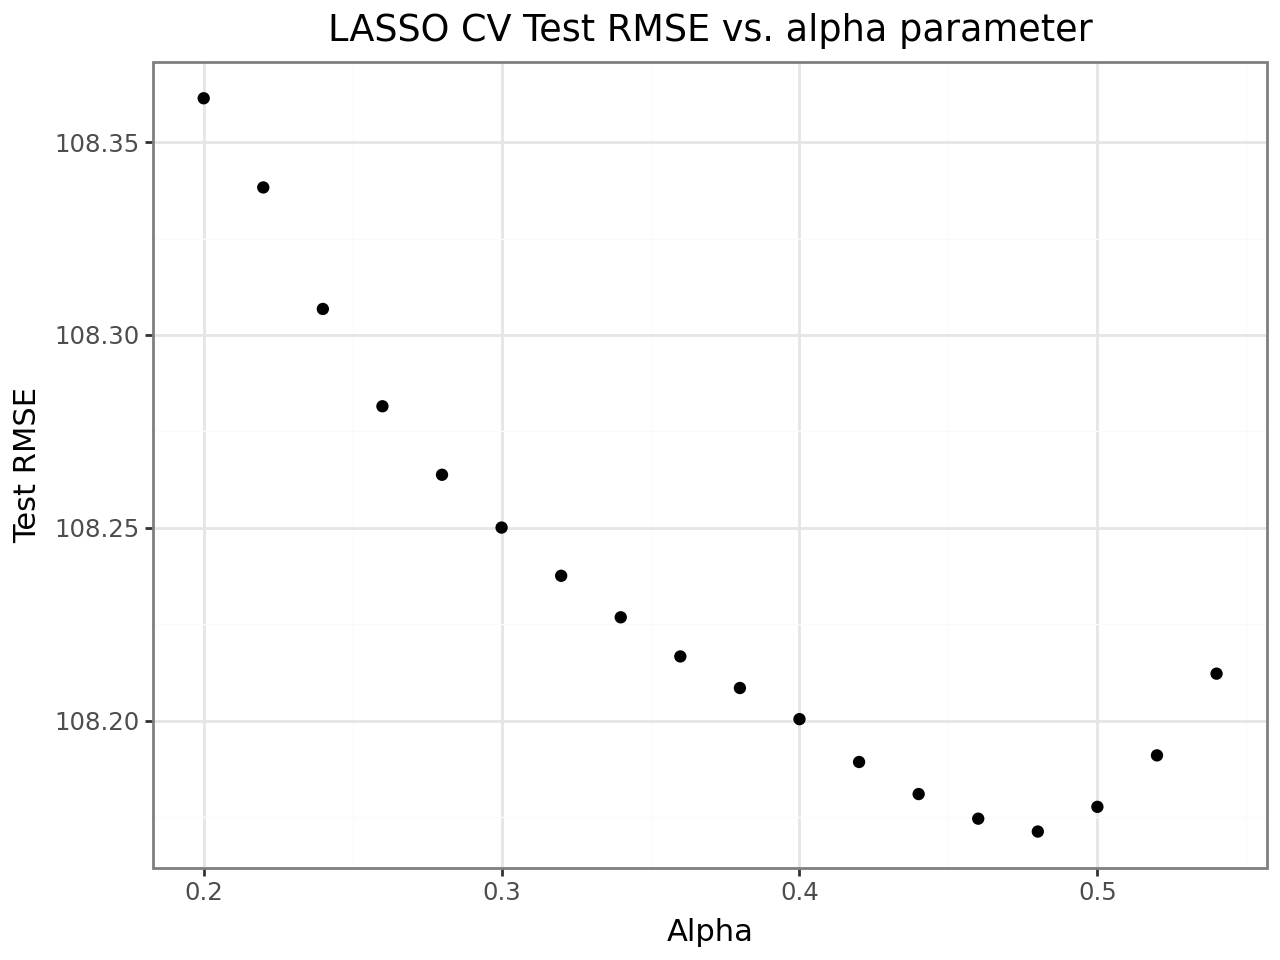

In [231]:
(
    ggplot(pd.DataFrame({'Alpha' : lasso_cv.cv_results_['param_alpha'].data, 'Test RMSE' : lasso_cv.cv_results_['mean_test_score']*-1}),
           aes('Alpha', 'Test RMSE')) + geom_point() + theme_bw() + labs(title = 'LASSO CV Test RMSE vs. alpha parameter')
)

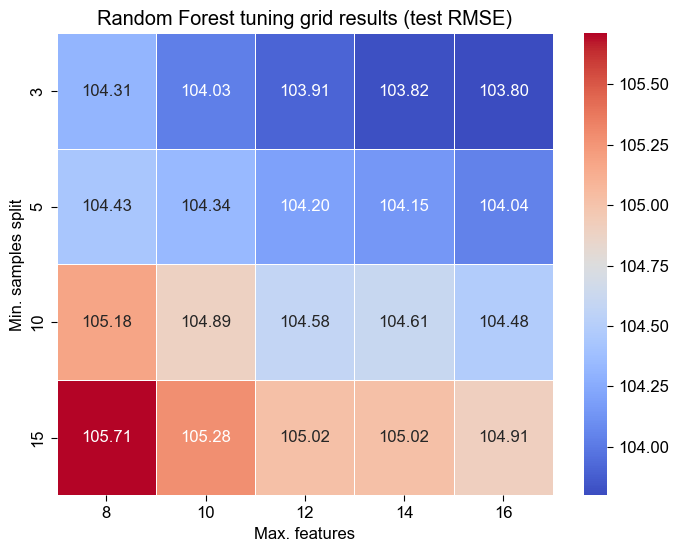

In [248]:
heatmap_data = pd.DataFrame(rf_cv.cv_results_)[
    ["param_max_features", "param_min_samples_split", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Variables=lambda x: x["param_max_features"],
    Min_nodes=lambda x: x["param_min_samples_split"],
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(2)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.xlabel("Max. features")
plt.ylabel("Min. samples split")
plt.title("Random Forest tuning grid results (test RMSE)")

plt.show()

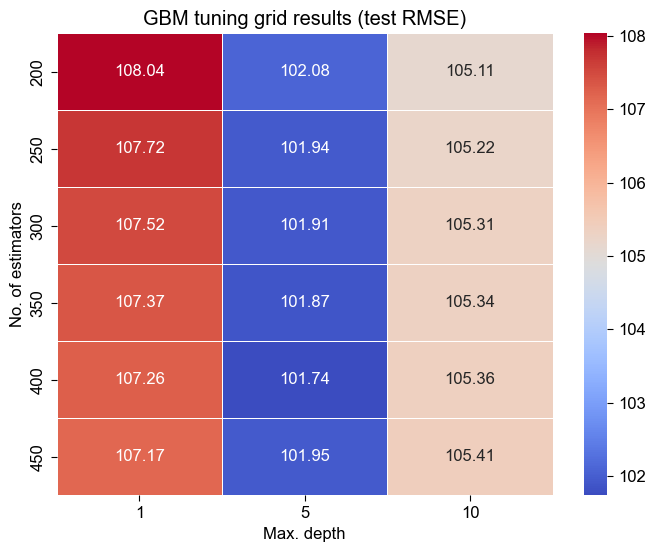

In [42]:
df = pd.DataFrame(gbm_cv.cv_results_)[
    ["param_max_depth", "param_n_estimators", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1
).pivot(
    index="param_n_estimators", columns="param_max_depth", values="mean_test_score"
)

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.xlabel("Max. depth")
plt.ylabel("No. of estimators")
plt.title("GBM tuning grid results (test RMSE)")
plt.show()


In [44]:
df = pd.DataFrame(xgb_cv.cv_results_)[[
    "mean_test_score",
    "param_colsample_bytree",
    "param_learning_rate",
    "param_max_depth",
    "param_min_child_weight",
    "param_n_estimators"
]].astype(float).round(2)

df.mean_test_score = df.mean_test_score * -1

df.sort_values(by = 'mean_test_score', ascending = True, inplace = True)

df.columns = ['Test RMSE', 'Col. subsample ratio', 'Learning rate', 'Max. depth', 'Min. child weight', 'No. of estimators']

df.reset_index(drop = True, inplace = True)

In [46]:
df.head(10)

,Test RMSE,Col. subsample ratio,Learning rate,Max. depth,Min. child weight,No. of estimators
0,100.51,0.6,0.05,9.0,20.0,450.0
1,100.52,0.6,0.05,9.0,20.0,350.0
2,100.65,0.8,0.05,9.0,20.0,350.0
3,100.68,0.8,0.05,9.0,20.0,450.0
4,100.69,0.6,0.05,9.0,10.0,350.0
5,100.70,0.6,0.05,9.0,10.0,450.0
6,100.70,0.6,0.05,9.0,20.0,250.0
7,100.73,0.8,0.05,9.0,20.0,250.0
8,100.79,0.6,0.05,6.0,10.0,450.0
9,100.81,0.6,0.05,6.0,20.0,450.0


In [48]:
df.tail(10)

,Test RMSE,Col. subsample ratio,Learning rate,Max. depth,Min. child weight,No. of estimators
98,103.97,0.6,0.05,3.0,20.0,350.0
99,104.05,0.8,0.05,3.0,20.0,350.0
100,104.10,1.0,0.05,3.0,10.0,350.0
101,104.11,1.0,0.05,3.0,20.0,350.0
102,104.46,0.6,0.05,3.0,10.0,250.0
103,104.47,0.6,0.05,3.0,20.0,250.0
104,104.51,0.8,0.05,3.0,10.0,250.0
105,104.61,0.8,0.05,3.0,20.0,250.0
106,104.64,1.0,0.05,3.0,20.0,250.0
107,104.66,1.0,0.05,3.0,10.0,250.0


To evaluate the model's performance on unseen data, we should re-estimate all of them (with the cross-validated tuning parameters) on the whole train sample (to utilize all available information). Note that we have already done this for the OLS model, so we should only deal with the other four. For easier use later, I incorporate the models into some pipelines.

In [255]:
categorical_columns = [col for col in predictors_ml if col.startswith("f_")]
numerical_columns = [col for col in predictors_ml if col not in categorical_columns]
categorical_encoder = OneHotEncoder(handle_unknown="ignore")
preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

In [257]:
y, X = dmatrices("eur_price" + ols_equations[5], data_train)
scaler = StandardScaler()
scaler.fit(X)
lasso_best_pipeline = Pipeline(
    [
        ("scale", scaler),
        ("regressor", lasso),
    ]
)
y, X = dmatrices("eur_price" + ols_equations[5], data_train) # dmatrices does the categorical encoding, so no need for the onehotencoder
lasso_best_pipeline.fit(X, y.ravel())

Pipeline(steps=[('scale', StandardScaler()),
                ('regressor',
                 ElasticNet(alpha=0.48, l1_ratio=1, random_state=9876))])

In [258]:
rf_best_pipeline = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", rf),
    ]
)
rf_best_pipeline.fit(data_train[list(predictors_ml)], data_train.eur_price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathrooms',
                                                   'f_host_location',
                                                   'f_host_response_time',
                                                   'f_host_listings_count',
                                                   'f_number_of_reviews']),
                                                 ('num', 'passthrough',
                                                  ['n_accomodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_distance_to_center',
                                                   'd_instant_bookable',
                                                   'n...
                                                   'd_amenities_heating',
                                                   'd_amenities_tv',
                                                   'd_amenities_hangers',
                                                   'd_amenities_wifi',
                                                   'd_amenities_kitchen',
                                                   'd_amenities_air_conditioning',
                                                   'd_amenities_elevator',
                                                   'd_amenities_essentials',
                                                   'd_amenities_first_aid_kit', ...])])),
                ('regressor',
                 RandomForestRegressor(max_features=16, min_samples_split=3,
                                       n_estimators=250, n_jobs=7,
                                       oob_score=True, random_state=485))])

In [260]:
gbm_best_pipeline = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", gbm),
    ]
)
gbm_best_pipeline.fit(data_train[list(predictors_ml)], data_train.eur_price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathrooms',
                                                   'f_host_location',
                                                   'f_host_response_time',
                                                   'f_host_listings_count',
                                                   'f_number_of_reviews']),
                                                 ('num', 'passthrough',
                                                  ['n_accomodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_distance_to_center',
                                                   'd_instant_bookable',
                                                   'n...
                                                   'flag_n_reviews_per_month',
                                                   'd_amenities_washer',
                                                   'd_amenities_heating',
                                                   'd_amenities_tv',
                                                   'd_amenities_hangers',
                                                   'd_amenities_wifi',
                                                   'd_amenities_kitchen',
                                                   'd_amenities_air_conditioning',
                                                   'd_amenities_elevator',
                                                   'd_amenities_essentials',
                                                   'd_amenities_first_aid_kit', ...])])),
                ('regressor',
                 GradientBoostingRegressor(max_depth=5, min_samples_split=20,
                                           n_estimators=400,
                                           random_state=31))])

In [262]:
xgb_best_pipeline = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", xgb),
    ]
)
xgb_best_pipeline.fit(data_train[list(predictors_ml)], data_train.eur_price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathrooms',
                                                   'f_host_location',
                                                   'f_host_response_time',
                                                   'f_host_listings_count',
                                                   'f_number_of_reviews']),
                                                 ('num', 'passthrough',
                                                  ['n_accomodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_distance_to_center',
                                                   'd_instant_bookable',
                                                   'n...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=9, max_leaves=None, min_child_weight=20,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=450,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=56, ...))])

# DON'T RUN FROM HERE!

Having refitted the models on the whole training set, we can now evaluate their performance on unseen data. For this, I make a prediction on the hold-out set with all of the models, than calculate the RMSE values of these predictions.

In [263]:
hold_out_rmse = {}

In [264]:
y, X = dmatrices("eur_price" + ols_equations[3], data_holdout)
hold_out_rmse['ols'] = mean_squared_error(y, ols.predict(X), squared = False)

In [265]:
y, X = dmatrices("eur_price" + ols_equations[5], data_holdout)
hold_out_rmse['lasso'] = mean_squared_error(y, lasso_best_pipeline.predict(X), squared = False)

In [266]:
hold_out_rmse['rf'] = mean_squared_error(data_holdout['eur_price'], rf_best_pipeline.predict(data_holdout[list(predictors_ml)]), squared = False)

In [267]:
hold_out_rmse['gbm'] = mean_squared_error(data_holdout['eur_price'], gbm_best_pipeline.predict(data_holdout[list(predictors_ml)]), squared = False)

In [268]:
hold_out_rmse['xgb'] = mean_squared_error(data_holdout['eur_price'], xgb_best_pipeline.predict(data_holdout[list(predictors_ml)]), squared = False)

Now that we have both training time and RMSE data, let's create a horserace chart! Note that I included an adjusted time column as well, as the OLS and LASSO models have not been estimated on multiple cores. Thus I included an adjustment for them, assuming 80% parallelization efficiency, so that the timing values become comparable.

In [269]:
horserace = pd.DataFrame({
    'Hold-out set RMSE': hold_out_rmse,
    'Training time (m)': model_times
})

def adjust_for_parallelization(time, num_cores=8, efficiency=0.8):
    return time / (num_cores * efficiency + (1 - efficiency))

horserace['Adj. training time (assuming all cores used, m)'] = horserace['Training time (m)']
horserace.loc[['ols', 'lasso'], 'Adj. training time (assuming all cores used, m)'] = horserace.loc[['ols', 'lasso'], 'Training time (m)'].apply(adjust_for_parallelization)
horserace.index = ['OLS', 'LASSO', 'Random Forest', 'GBM', 'XGBoost']

horserace['Hold-out set RMSE'] = round(horserace['Hold-out set RMSE'], 2)
horserace['Training time (m)'] = round(horserace['Training time (m)'] / 60, 2)
horserace['Adj. training time (assuming all cores used, m)'] = round(horserace['Adj. training time (assuming all cores used, m)'] / 60, 2)

In [270]:
horserace

,Hold-out set RMSE,Training time (m),"Adj. training time (assuming all cores used, m)"
OLS,100.05,0.36,0.05
LASSO,100.45,2.37,0.36
Random Forest,94.80,3.50,3.50
GBM,93.46,17.52,17.52
XGBoost,92.01,5.36,5.36


### 1.4. Analysis of Random Forest and XGBoost models

To analyze and somewhat understand the Random Forest and XGBoost models, I first draw up some variable importance plots. Importantly, I calculate grouped importance values for factor variables.

I present trees showing all variables above a 1% importance cutoff, and also separately only the top 10 most important variables.

In [281]:
result = permutation_importance(
    rf_best_pipeline,
    data_train[list(predictors_ml)],
    data_train.eur_price,
    n_repeats=10,
    random_state=45,
    n_jobs=-1,
)

In [282]:
grouped_imp = (
    pd.DataFrame(result.importances_mean, data_train[list(predictors_ml)].columns)
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
)

In [283]:
rf_varimp_plot_all = (
    ggplot(
        grouped_imp.loc[lambda x: x.imp_percentage > 0.01],
        aes(x="reorder(varname, imp)", y="imp_percentage"),
    )
    + geom_point(color=color[0], size=2.5)
    + geom_segment(
        aes(x="varname", xend="varname", y=0, yend="imp_percentage"),
        color=color[0],
        size=2,
    )
    + ylab("Importance (Percent)")
    + xlab("Variable Name")
    + coord_flip()
    + ggtitle("Random Forest - Variable importance (above 1% cutoff)")
    + scale_y_continuous(labels=percent_format())
    + theme_bw()
)

rf_varimp_plot_top = (
    ggplot(
        grouped_imp.head(10),
        aes(x="reorder(varname, imp)", y="imp_percentage"),
    )
    + geom_point(color=color[0], size=2.5)
    + geom_segment(
        aes(x="varname", xend="varname", y=0, yend="imp_percentage"),
        color=color[0],
        size=2,
    )
    + ylab("Importance (Percent)")
    + xlab("Variable Name")
    + coord_flip()
    + ggtitle("Random Forest - Top 10 most important variables")
    + scale_y_continuous(labels=percent_format())
    + theme_bw()
)

In [284]:
xgb_result = permutation_importance(
    xgb_best_pipeline,
    data_train[list(predictors_ml)],
    data_train.eur_price,
    n_repeats=10,
    random_state=45,
    n_jobs=-1,
)

In [285]:
xgb_grouped_imp = (
    pd.DataFrame(xgb_result.importances_mean, data_train[list(predictors_ml)].columns)
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
)

In [286]:
xgb_varimp_plot_all = (
    ggplot(
        xgb_grouped_imp.loc[lambda x: x.imp_percentage > 0.01],
        aes(x="reorder(varname, imp)", y="imp_percentage"),
    )
    + geom_point(color=color[0], size=2.5)
    + geom_segment(
        aes(x="varname", xend="varname", y=0, yend="imp_percentage"),
        color=color[0],
        size=2,
    )
    + ylab("Importance (Percent)")
    + xlab("Variable Name")
    + coord_flip()
    + ggtitle("XGBoost - Variable importance (above 1% cutoff)")
    + scale_y_continuous(labels=percent_format())
    + theme_bw()
)

xgb_varimp_plot_top = (
    ggplot(
        xgb_grouped_imp.head(10),
        aes(x="reorder(varname, imp)", y="imp_percentage"),
    )
    + geom_point(color=color[0], size=2.5)
    + geom_segment(
        aes(x="varname", xend="varname", y=0, yend="imp_percentage"),
        color=color[0],
        size=2,
    )
    + ylab("Importance (Percent)")
    + xlab("Variable Name")
    + coord_flip()
    + ggtitle("XGBoost - Top 10 most important variables")
    + scale_y_continuous(labels=percent_format())
    + theme_bw()
)

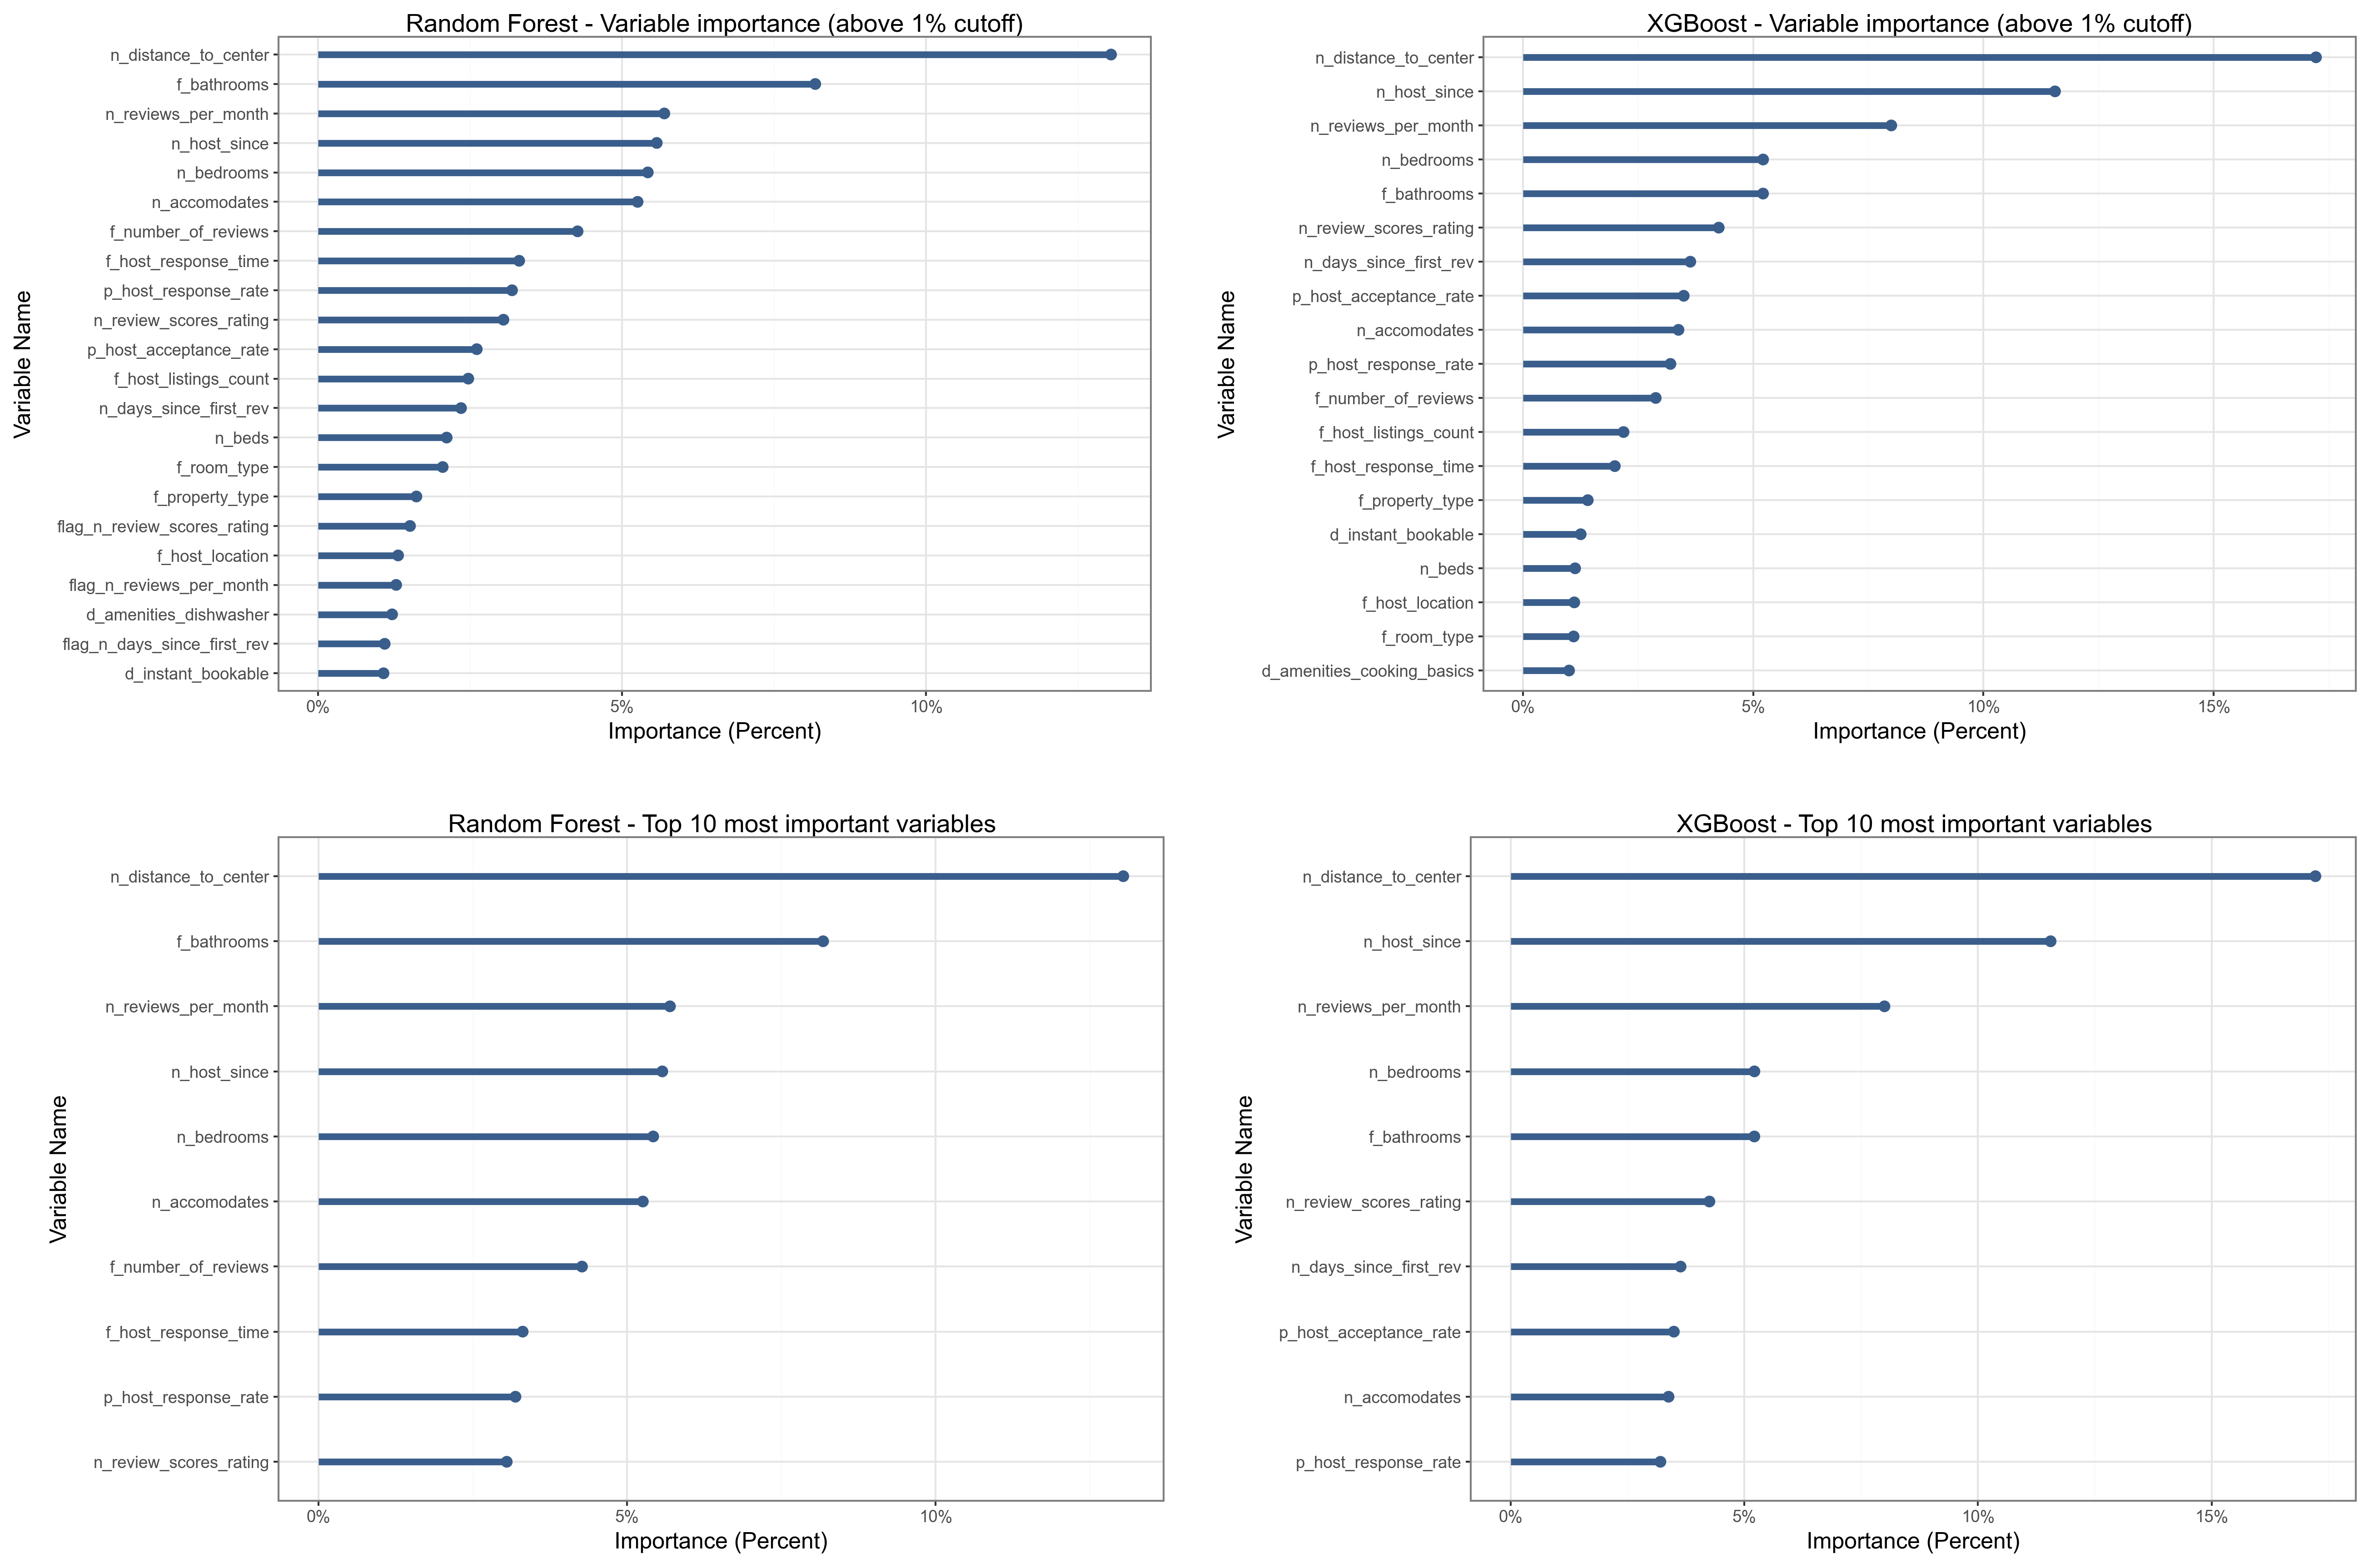

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [287]:
pw.basefigure.clear()
display((pw.load_ggplot(rf_varimp_plot_all) | pw.load_ggplot(xgb_varimp_plot_all)) / ((pw.load_ggplot(rf_varimp_plot_top) | pw.load_ggplot(xgb_varimp_plot_top))))

In [288]:
X_encoded = rf_best_pipeline["preprocess"].transform(data_holdout.filter(list(predictors_ml)))
new_feature_names = [
    i.replace("cat__", "").replace("num__", "")
    for i in rf_best_pipeline["preprocess"].get_feature_names_out()
]
X_holdout = pd.DataFrame(X_encoded, columns=new_feature_names)

# without approximation, running this took many hours
rf_explainer = shap.TreeExplainer(rf_best_pipeline["regressor"], approximate = True)
rf_shap_values = rf_explainer(X_holdout)

In [289]:
with open(Path("rf_shap_values.dill"), "wb") as f:
    dill.dump(rf_shap_values, f)

In [135]:
X_encoded = xgb_best_pipeline["preprocess"].transform(data_holdout.filter(list(predictors_ml)))
new_feature_names = [
    i.replace("cat__", "").replace("num__", "")
    for i in xgb_best_pipeline["preprocess"].get_feature_names_out()
]
X_holdout = pd.DataFrame(X_encoded, columns=new_feature_names)

xgb_explainer = shap.TreeExplainer(xgb_best_pipeline["regressor"])
xgb_shap_values = xgb_explainer(X_holdout)

In [137]:
with open(Path("xgb_shap_values.dill"), "wb") as f:
    dill.dump(xgb_shap_values, f)

# RUN FROM HERE AGAIN

In [290]:
with open(Path("rf_shap_values.dill"), "rb") as f:
    rf_shap_values = dill.load(f)
with open(Path("xgb_shap_values.dill"), "rb") as f:
    xgb_shap_values = dill.load(f)

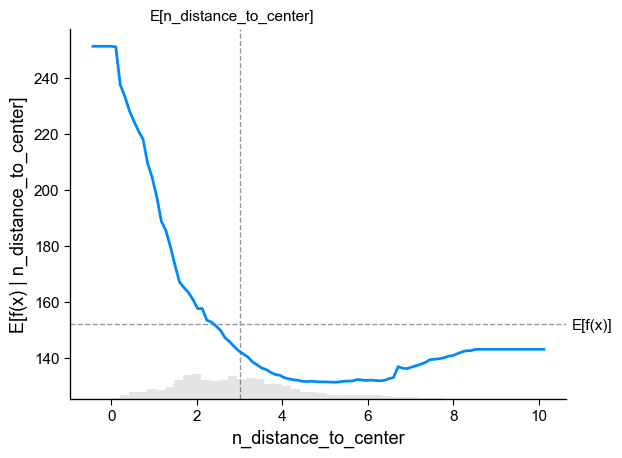

In [291]:
shap.partial_dependence_plot(
    'n_distance_to_center',
    rf_best_pipeline.predict,
    data_holdout,
    model_expected_value=True,
    feature_expected_value=True,
    show=True,
    ice=False
)

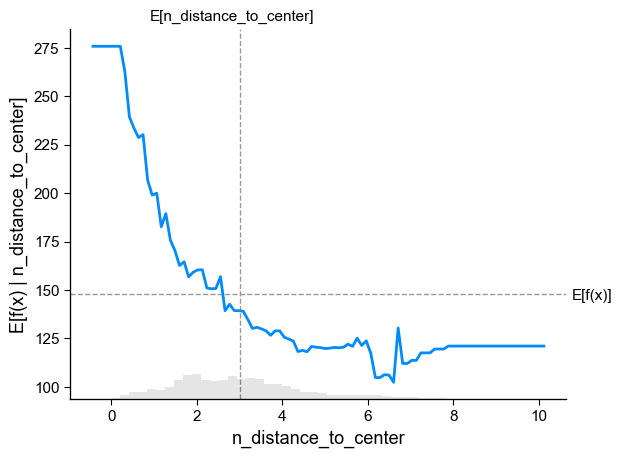

In [292]:
shap.partial_dependence_plot(
    'n_distance_to_center',
    xgb_best_pipeline.predict,
    data_holdout,
    model_expected_value=True,
    feature_expected_value=True,
    show=True,
    ice=False
)

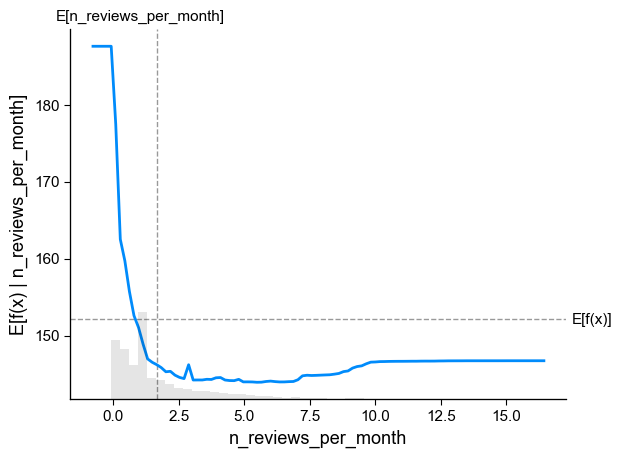

In [293]:
shap.partial_dependence_plot(
    'n_reviews_per_month',
    rf_best_pipeline.predict,
    data_holdout,
    model_expected_value=True,
    feature_expected_value=True,
    show=True,
    ice=False
)

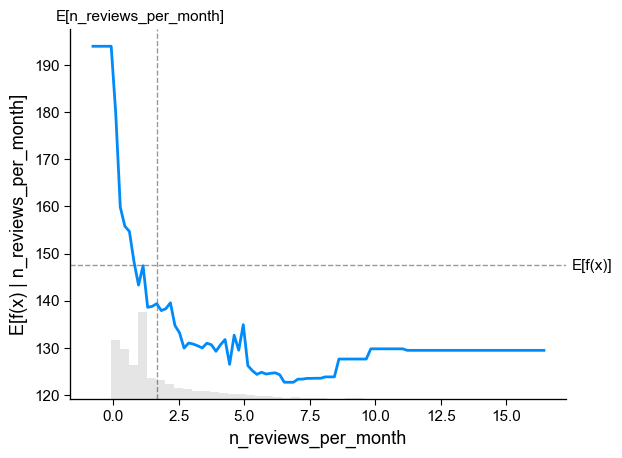

In [294]:
shap.partial_dependence_plot(
    'n_reviews_per_month',
    xgb_best_pipeline.predict,
    data_holdout,
    model_expected_value=True,
    feature_expected_value=True,
    show=True,
    ice=False
)

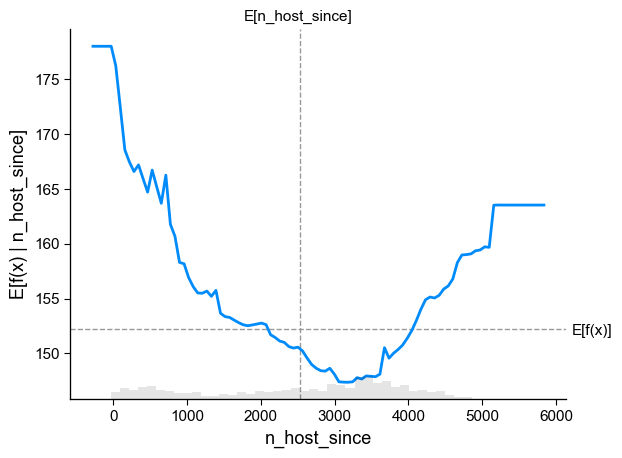

In [295]:
shap.partial_dependence_plot(
    'n_host_since',
    rf_best_pipeline.predict,
    data_holdout,
    model_expected_value=True,
    feature_expected_value=True,
    show=True,
    ice=False
)

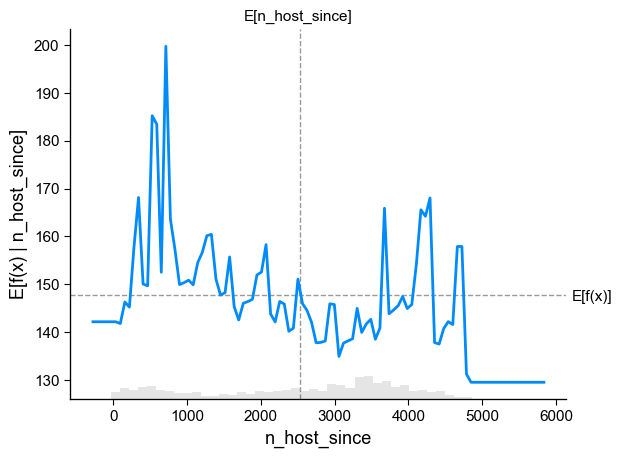

In [296]:
shap.partial_dependence_plot(
    'n_host_since',
    xgb_best_pipeline.predict,
    data_holdout,
    model_expected_value=True,
    feature_expected_value=True,
    show=True,
    ice=False
)

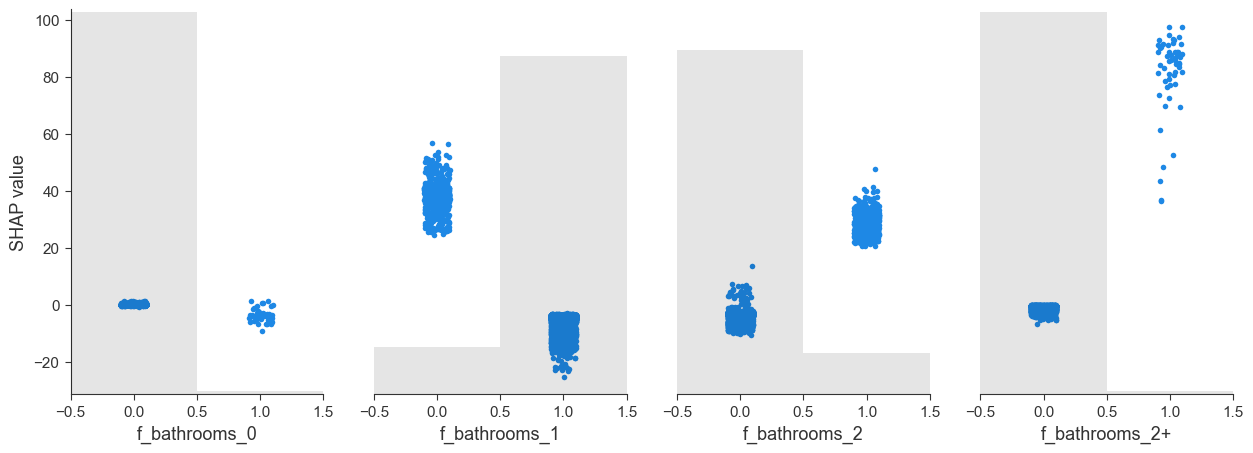

In [297]:
shap.plots.scatter(rf_shap_values[:, ['f_bathrooms_0', 'f_bathrooms_1', 'f_bathrooms_2', 'f_bathrooms_2+']])

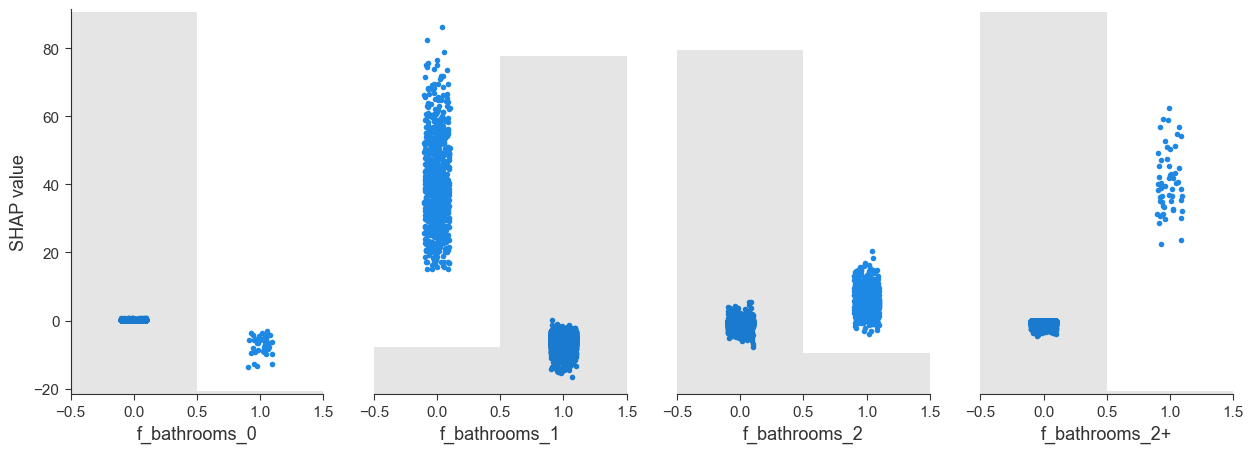

In [298]:
shap.plots.scatter(xgb_shap_values[:, ['f_bathrooms_0', 'f_bathrooms_1', 'f_bathrooms_2', 'f_bathrooms_2+']])

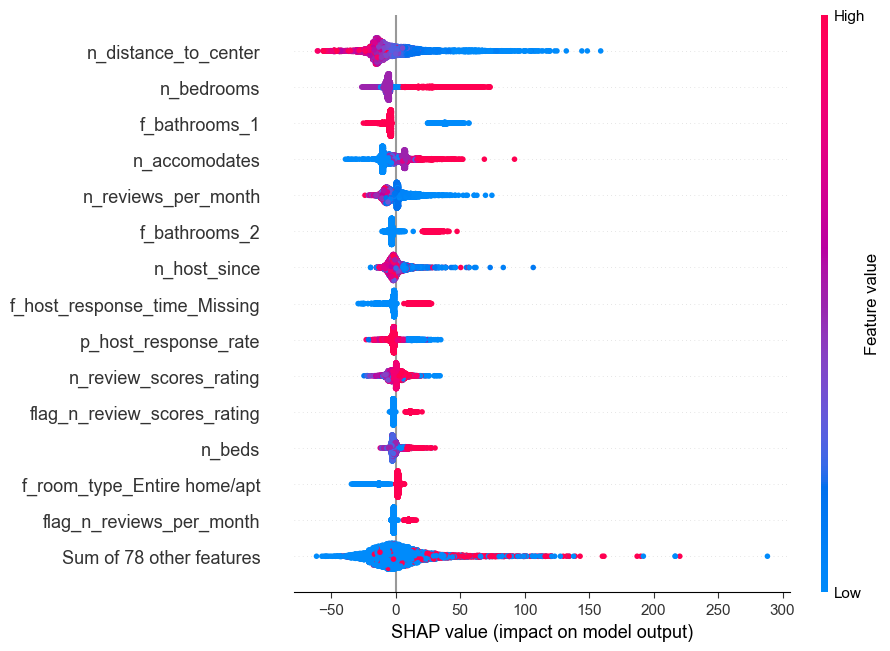

In [299]:
shap.plots.beeswarm(rf_shap_values, max_display = 15, show = True)

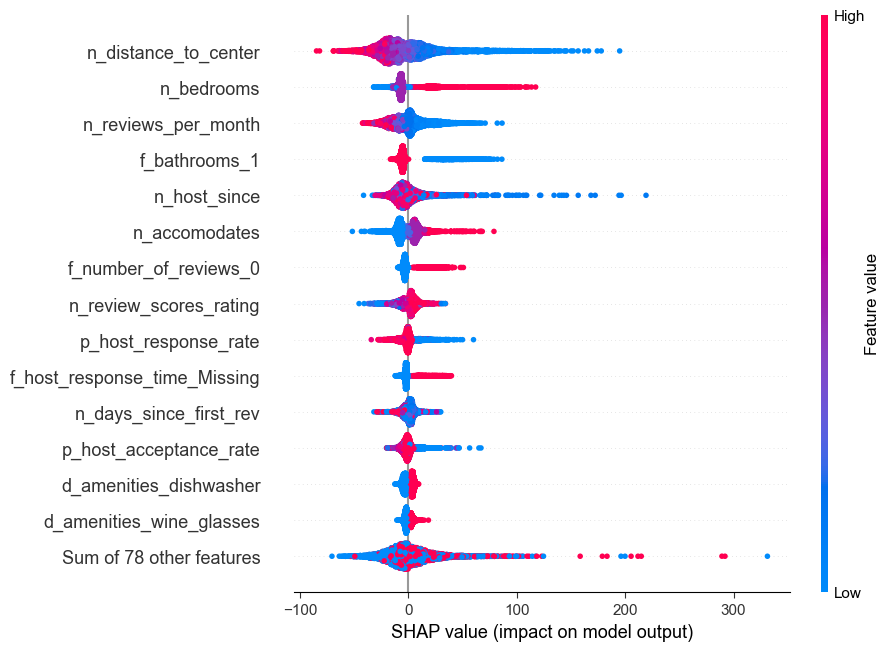

In [300]:
shap.plots.beeswarm(xgb_shap_values, max_display = 15, show = True)

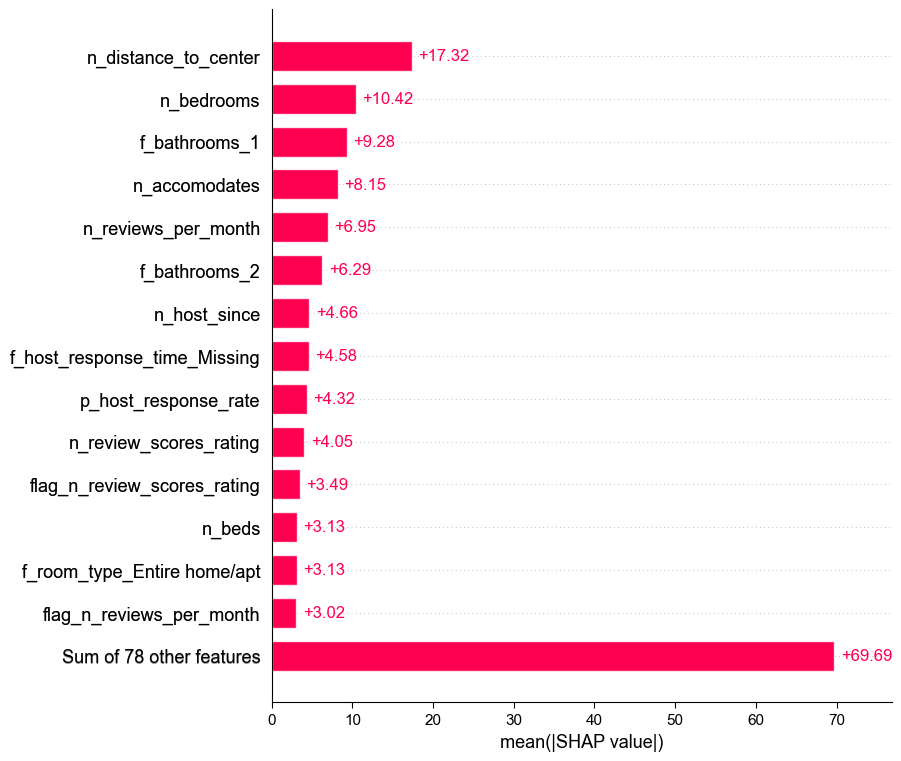

In [301]:
shap.plots.bar(rf_shap_values, max_display = 15, show = True)

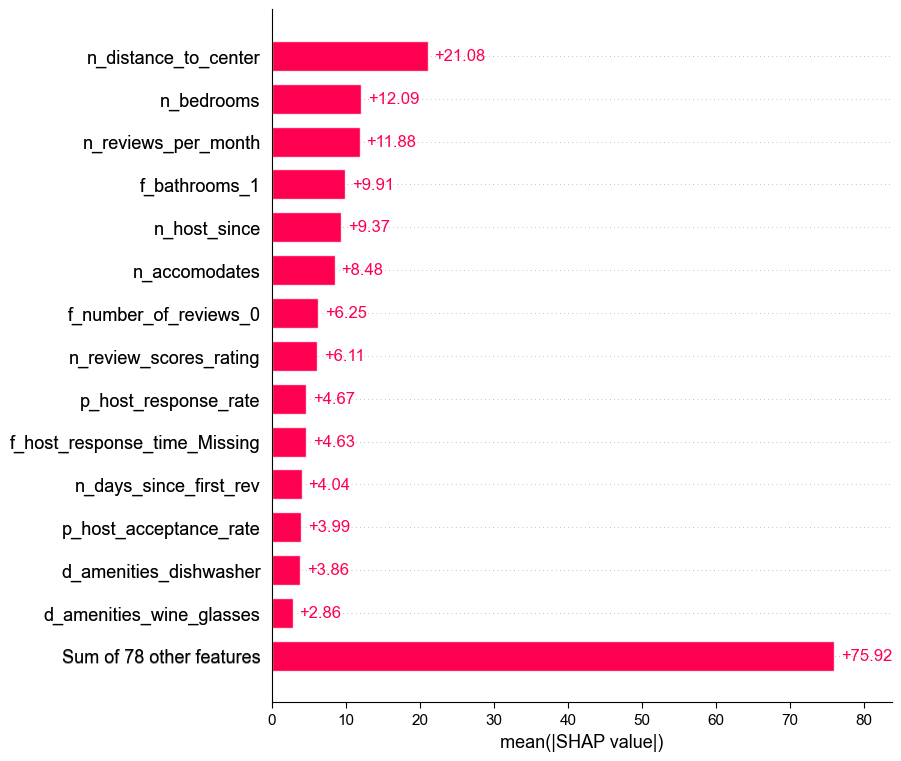

In [302]:
shap.plots.bar(xgb_shap_values, max_display = 15, show = True)

## Part 2: Validity
### 2.5. 'Live' dataset import and cleaning

This has already been done (see section 1.1).

### 2.6. Evaluating model performance on 'live' data

First, to utilize all available training data, I will re-estimate all models using the complete MilanQ2 dataset.

In [320]:
y, X = dmatrices("eur_price" + ols_equations[3], milanQ2)
ols_complete = LinearRegression().fit(X, y)

In [322]:
y, X = dmatrices("eur_price" + ols_equations[5], milanQ2)
lasso_best_pipeline.fit(X, y.ravel())

Pipeline(steps=[('scale', StandardScaler()),
                ('regressor',
                 ElasticNet(alpha=0.48, l1_ratio=1, random_state=9876))])

In [323]:
rf_best_pipeline.fit(milanQ2[list(predictors_ml)], milanQ2.eur_price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathrooms',
                                                   'f_host_location',
                                                   'f_host_response_time',
                                                   'f_host_listings_count',
                                                   'f_number_of_reviews']),
                                                 ('num', 'passthrough',
                                                  ['n_accomodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_distance_to_center',
                                                   'd_instant_bookable',
                                                   'n...
                                                   'd_amenities_heating',
                                                   'd_amenities_tv',
                                                   'd_amenities_hangers',
                                                   'd_amenities_wifi',
                                                   'd_amenities_kitchen',
                                                   'd_amenities_air_conditioning',
                                                   'd_amenities_elevator',
                                                   'd_amenities_essentials',
                                                   'd_amenities_first_aid_kit', ...])])),
                ('regressor',
                 RandomForestRegressor(max_features=16, min_samples_split=3,
                                       n_estimators=250, n_jobs=7,
                                       oob_score=True, random_state=485))])

In [324]:
gbm_best_pipeline.fit(milanQ2[list(predictors_ml)], milanQ2.eur_price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathrooms',
                                                   'f_host_location',
                                                   'f_host_response_time',
                                                   'f_host_listings_count',
                                                   'f_number_of_reviews']),
                                                 ('num', 'passthrough',
                                                  ['n_accomodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_distance_to_center',
                                                   'd_instant_bookable',
                                                   'n...
                                                   'flag_n_reviews_per_month',
                                                   'd_amenities_washer',
                                                   'd_amenities_heating',
                                                   'd_amenities_tv',
                                                   'd_amenities_hangers',
                                                   'd_amenities_wifi',
                                                   'd_amenities_kitchen',
                                                   'd_amenities_air_conditioning',
                                                   'd_amenities_elevator',
                                                   'd_amenities_essentials',
                                                   'd_amenities_first_aid_kit', ...])])),
                ('regressor',
                 GradientBoostingRegressor(max_depth=5, min_samples_split=20,
                                           n_estimators=400,
                                           random_state=31))])

In [325]:
xgb_best_pipeline.fit(milanQ2[list(predictors_ml)], milanQ2.eur_price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathrooms',
                                                   'f_host_location',
                                                   'f_host_response_time',
                                                   'f_host_listings_count',
                                                   'f_number_of_reviews']),
                                                 ('num', 'passthrough',
                                                  ['n_accomodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_distance_to_center',
                                                   'd_instant_bookable',
                                                   'n...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=9, max_leaves=None, min_child_weight=20,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=450,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=56, ...))])

Now we can make some predictions on the live datasets. Importantly, in a real use case, we would have no way to calculate RMSE values for the live data (as it would be live, without price values available). However, we now have price inside our live sets as well, so we can calculate the models' RMSE values there as well.

An important caveat, however, is that before, I intentionally did not filter out observations with possible errors in the price variable (as in real live data, we could not do that). However, when calculating the RMSE values, these errors very much inflate the results. So, I below present two RMSE values for both datasets: one without filtering out erronous prices, and one with filtering these out. I believe this second measure captures much better how well my models generalize to other time periods or other areas.

In [326]:
milanQ3_rmse = {}
y, X = dmatrices("eur_price" + ols_equations[3], milanQ3)
milanQ3_rmse['ols'] = mean_squared_error(y, ols_complete.predict(X), squared = False)
y, X = dmatrices("eur_price" + ols_equations[5], milanQ3)
milanQ3_rmse['lasso'] = mean_squared_error(y, lasso_best_pipeline.predict(X), squared = False)
milanQ3_rmse['rf'] = mean_squared_error(milanQ3['eur_price'], rf_best_pipeline.predict(milanQ3[list(predictors_ml)]), squared = False)
milanQ3_rmse['gbm'] = mean_squared_error(milanQ3['eur_price'], gbm_best_pipeline.predict(milanQ3[list(predictors_ml)]), squared = False)
milanQ3_rmse['xgb'] = mean_squared_error(milanQ3['eur_price'], xgb_best_pipeline.predict(milanQ3[list(predictors_ml)]), squared = False)

In [328]:
milanQ3_clean = milanQ3[milanQ3['eur_price'] <= 1000]

In [329]:
milanQ3_clean_rmse = {}
y, X = dmatrices("eur_price" + ols_equations[3], milanQ3_clean)
milanQ3_clean_rmse['ols'] = mean_squared_error(y, ols_complete.predict(X), squared = False)
y, X = dmatrices("eur_price" + ols_equations[5], milanQ3_clean)
milanQ3_clean_rmse['lasso'] = mean_squared_error(y, lasso_best_pipeline.predict(X), squared = False)
milanQ3_clean_rmse['rf'] = mean_squared_error(milanQ3_clean['eur_price'], rf_best_pipeline.predict(milanQ3_clean[list(predictors_ml)]), squared = False)
milanQ3_clean_rmse['gbm'] = mean_squared_error(milanQ3_clean['eur_price'], gbm_best_pipeline.predict(milanQ3_clean[list(predictors_ml)]), squared = False)
milanQ3_clean_rmse['xgb'] = mean_squared_error(milanQ3_clean['eur_price'], xgb_best_pipeline.predict(milanQ3_clean[list(predictors_ml)]), squared = False)

In [330]:
florenceQ2_rmse = {}
y, X = dmatrices("eur_price" + ols_equations[3], florenceQ2)
florenceQ2_rmse['ols'] = mean_squared_error(y, ols_complete.predict(X), squared = False)
y, X = dmatrices("eur_price" + ols_equations[5], florenceQ2)
florenceQ2_rmse['lasso'] = mean_squared_error(y, lasso_best_pipeline.predict(X), squared = False)
florenceQ2_rmse['rf'] = mean_squared_error(florenceQ2['eur_price'], rf_best_pipeline.predict(florenceQ2[list(predictors_ml)]), squared = False)
florenceQ2_rmse['gbm'] = mean_squared_error(florenceQ2['eur_price'], gbm_best_pipeline.predict(florenceQ2[list(predictors_ml)]), squared = False)
florenceQ2_rmse['xgb'] = mean_squared_error(florenceQ2['eur_price'], xgb_best_pipeline.predict(florenceQ2[list(predictors_ml)]), squared = False)

In [331]:
florenceQ2_clean = florenceQ2[florenceQ2['eur_price'] <= 1000]

In [333]:
florenceQ2_clean_rmse = {}
y, X = dmatrices("eur_price" + ols_equations[3], florenceQ2_clean)
florenceQ2_clean_rmse['ols'] = mean_squared_error(y, ols_complete.predict(X), squared = False)
y, X = dmatrices("eur_price" + ols_equations[5], florenceQ2_clean)
florenceQ2_clean_rmse['lasso'] = mean_squared_error(y, lasso_best_pipeline.predict(X), squared = False)
florenceQ2_clean_rmse['rf'] = mean_squared_error(florenceQ2_clean['eur_price'], rf_best_pipeline.predict(florenceQ2_clean[list(predictors_ml)]), squared = False)
florenceQ2_clean_rmse['gbm'] = mean_squared_error(florenceQ2_clean['eur_price'], gbm_best_pipeline.predict(florenceQ2_clean[list(predictors_ml)]), squared = False)
florenceQ2_clean_rmse['xgb'] = mean_squared_error(florenceQ2_clean['eur_price'], xgb_best_pipeline.predict(florenceQ2_clean[list(predictors_ml)]), squared = False)

In [334]:
live_rmse = pd.DataFrame({
    'Milan Q3 RMSE' : milanQ3_rmse,
    'Milan Q3 RMSE (price errors removed)' : milanQ3_clean_rmse,
    'Florence Q2 RMSE' : florenceQ2_rmse,
    'Florence Q2 RMSE (price errors removed)' : florenceQ2_clean_rmse
}).round(2)

live_rmse.index = ['OLS', 'LASSO', 'Random Forest', 'GBM', 'XGBoost']

live_rmse

,Milan Q3 RMSE,Milan Q3 RMSE (price errors removed),Florence Q2 RMSE,Florence Q2 RMSE (price errors removed)
OLS,1131.13,114.37,263.09,115.00
LASSO,1131.38,115.20,264.68,116.21
Random Forest,1128.89,95.58,263.52,115.20
GBM,1129.07,104.86,263.29,120.53
XGBoost,1128.82,99.23,262.47,116.01
